# Profiling MIEDA's Speed and Computational Complexity

This notebook illustrates the scalability of MIEDA as the number of intervals continues to grow. By taking advantage of sorting and a directed-graph in place of recursion, MIEDA is able to scale with relative effectiveness to a large number of intervals - MIEDA is of _(n)log(n)_ complexity. 

Experiements provided in [our published work]() were performed utilizing hardware with the following specifications: 

- 2.9 GHz Intel Core i7 (2016)
    - 4 cores
    - 256KB L2 Cache
    - 8MB L3 Cache
- 16GB 2133 MHz LPDDR3 RAM

At the time of writing and publication, MIEDA exists as a single-threaded application and the following experiments are reflective of that characteristic.

## Imports 

In [1]:
# let's make sure we are using the correct kernel 
import sys; sys.executable

'/usr/local/anaconda3/bin/python'

In [2]:
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
from mieda.intervals import Merge
from comparisons.iterative import Merge as it_merge

In [4]:
# plotting and other things 
import datetime
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from tqdm.notebook import tqdm

## Computation Time as Input Size (Number of Intervals) Increases 

We will construct a test to see how the speed scales as the number of intervals increases. For this test, we will use the most common scenario, where interval B starts after interval A and ends after interval A. We will also conduct multiple runs to get a more compregensive idea of the computation time as the input size (number of intervals) increases. 

In [5]:
# define the default interval which will be updated at each iteration 
seed_interval = [
    {"start": datetime.datetime(2020, 1, 1, 1, 0, 0), "finish": datetime.datetime(2020, 1, 4, 1, 0, 0),
     "set_items": {"1"}}
]

In [6]:
seed_interval

[{'start': datetime.datetime(2020, 1, 1, 1, 0),
  'finish': datetime.datetime(2020, 1, 4, 1, 0),
  'set_items': {'1'}}]

In [7]:
# generate a range of values for the length of the set of intervals 
interval_counts = list(range(0, 1000, 10))
interval_counts[0:10]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [8]:
# generate the input data for the test 
intervals = list()
inputs = list()

for i in tqdm(interval_counts):
    
    intervals = seed_interval + list() 
        
    for j in range(i):
        
        # get the last interval 
        update_interval = intervals[-1]
                    
        # add 2 hours to the start and end times 
        new_interval = update_interval.copy()
        new_interval["start"] = update_interval["start"] + datetime.timedelta(hours=2)
        new_interval["finish"] = update_interval["finish"] + datetime.timedelta(hours=2)
        
        # update the set items
        new_interval["set_items"] = {str(j)}
                
        intervals.append(new_interval)
        
    inputs.append(intervals)

In [9]:
# examine the output
inputs[1]

[{'start': datetime.datetime(2020, 1, 1, 1, 0),
  'finish': datetime.datetime(2020, 1, 4, 1, 0),
  'set_items': {'1'}},
 {'start': datetime.datetime(2020, 1, 1, 3, 0),
  'finish': datetime.datetime(2020, 1, 4, 3, 0),
  'set_items': {'0'}},
 {'start': datetime.datetime(2020, 1, 1, 5, 0),
  'finish': datetime.datetime(2020, 1, 4, 5, 0),
  'set_items': {'1'}},
 {'start': datetime.datetime(2020, 1, 1, 7, 0),
  'finish': datetime.datetime(2020, 1, 4, 7, 0),
  'set_items': {'2'}},
 {'start': datetime.datetime(2020, 1, 1, 9, 0),
  'finish': datetime.datetime(2020, 1, 4, 9, 0),
  'set_items': {'3'}},
 {'start': datetime.datetime(2020, 1, 1, 11, 0),
  'finish': datetime.datetime(2020, 1, 4, 11, 0),
  'set_items': {'4'}},
 {'start': datetime.datetime(2020, 1, 1, 13, 0),
  'finish': datetime.datetime(2020, 1, 4, 13, 0),
  'set_items': {'5'}},
 {'start': datetime.datetime(2020, 1, 1, 15, 0),
  'finish': datetime.datetime(2020, 1, 4, 15, 0),
  'set_items': {'6'}},
 {'start': datetime.datetime(2020,

In [10]:
def measureBulkTime(func, runs=10):
    run_interval_counts = list()
    run_seconds_elapsed = list()

    for r in range(runs):
        print("\n--- run " + str(r + 1) + " ---")
        interval_count = list()
        seconds_elapsed = list()
        flops_used = list()
        for i in tqdm(inputs):
            interval_count.append(len(i))
            start = time.process_time()
            func(i)
            seconds_elapsed.append(time.process_time() - start)

        run_interval_counts.append(interval_count)
        run_seconds_elapsed.append(seconds_elapsed)
    
    return (run_interval_counts, run_seconds_elapsed)
    

In [11]:
# for each, use mieda to overlap the intervals and create new sets in the intervals through a union merge 
# track how long it takes for each set of intervals to arrive at a profile of speed based on the input size 
run_interval_counts, run_seconds_elapsed = measureBulkTime(Merge.union, 10)


--- run 1 ---




--- run 2 ---




--- run 3 ---




--- run 4 ---




--- run 5 ---




--- run 6 ---




--- run 7 ---




--- run 8 ---




--- run 9 ---




--- run 10 ---


In [82]:
def plotMultiSpeed(trials):
    # flatten the list of runs for plotting 
    flattened_interval_counts = []
    flattened_seconds_elapsed = []
    algorithm_used = []
    algorithms = []
    for i, trial in enumerate(trials):
        flattened_trial_interval_counts = [item for sublist in trial["interval_count"] for item in sublist]
        flattened_trial_seconds_elapsed = [item for sublist in trial["seconds_elapsed"] for item in sublist]
        flattened_interval_counts += flattened_trial_interval_counts
        flattened_seconds_elapsed += flattened_trial_seconds_elapsed
        algorithm_used += [i] * len(flattened_trial_seconds_elapsed)
        algorithms.append(trial["algorithm"])

    df_runs = pd.DataFrame(
        np.array([flattened_interval_counts, flattened_seconds_elapsed, algorithm_used]).T,
        columns=["interval_count", "seconds_elapsed", "algorithm"]
    )
    
    g = sns.lmplot(
        x="interval_count", 
        y="seconds_elapsed", 
        data=df_runs,
        order=2,
        height=7,
        aspect=1.5,
        legend_out=False,
        hue="algorithm",
        palette=['#4daf4a','#1f78b4','#e41a1c','#7570b3'],
        line_kws={"lw":4, 'ls':'--'}
    )
    g.set(ylim=(-.05, 10), xlim=(0, 1010))
    ax = plt.gca()
    ax.set_title('Seconds Elapsed by Interval Count')
    ax.set(xlabel='\nInterval Count', ylabel='Seconds Elapsed\n')
    
    legend = g.axes[0, 0].get_legend()
    for i, text in enumerate(legend.texts):
        legend.texts[i].set_text(algorithms[i])

In [73]:
def plotSingleSpeed(run_interval_counts, run_seconds_elapsed):
    # flatten the list of runs for plotting 
    flattened_interval_counts = [item for sublist in run_interval_counts for item in sublist]
    flattened_seconds_elapsed = [item for sublist in run_seconds_elapsed for item in sublist]
    df_runs = pd.DataFrame(
        np.array([flattened_interval_counts, flattened_seconds_elapsed]).T,
        columns=["interval_count", "seconds_elapsed"]
    )
    
    g = sns.lmplot(
        x="interval_count", 
        y="seconds_elapsed", 
        data=df_runs,
        order=2,
        height=7,
        aspect=1.5,
        line_kws={'color': 'red'}
    )
    g.set(ylim=(-.05, 1.5))
    ax = plt.gca()
    ax.set_title('Seconds Elapsed by Interval Count')
    ax.set(xlabel='\nInterval Count', ylabel='Seconds Elapsed\n')

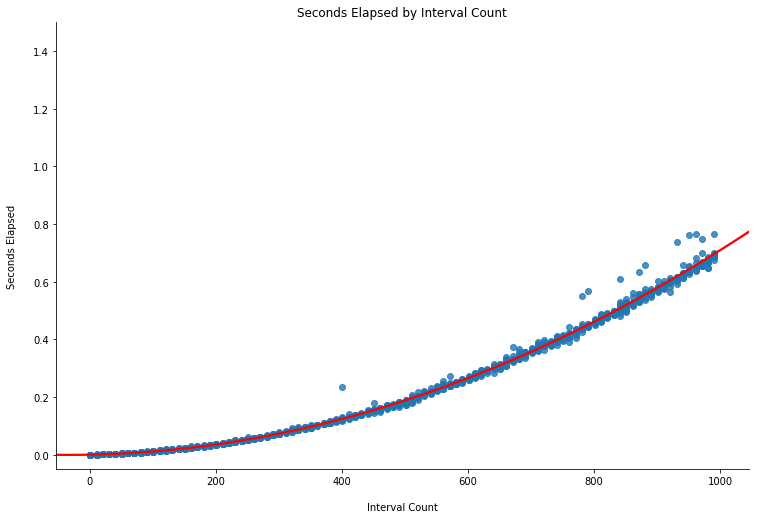

In [13]:
# Graph speed of mieda algorithm on increasing number of intervals
plotSingleSpeed(run_interval_counts, run_seconds_elapsed)

In [58]:
iterative_counts, iterative_time = measureBulkTime(it_merge.union, 1)


--- run 1 ---


In [59]:
algorithms = [
    {
        "interval_count": run_interval_counts,
        "seconds_elapsed": run_seconds_elapsed,
        "algorithm": "mieda"
    },
    {
        "interval_count": iterative_counts,
        "seconds_elapsed": iterative_time,
        "algorithm": "iterative"
    }
]

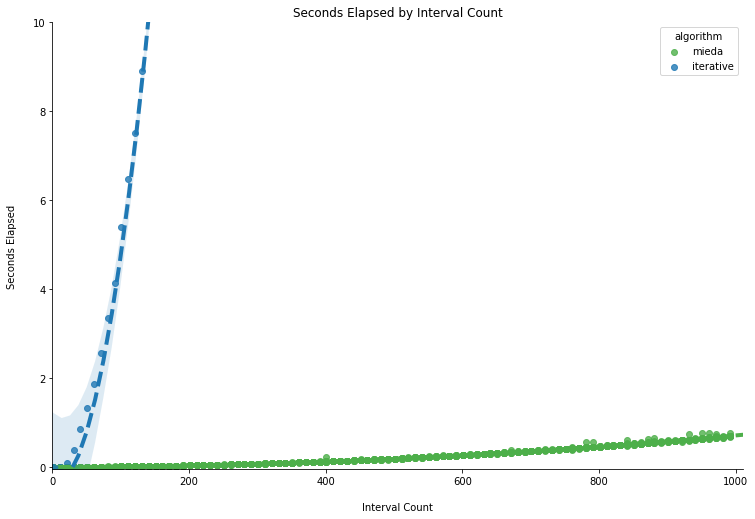

In [83]:
plotMultiSpeed(algorithms)

In [ ]:
# TODO: do a comparison to recursion! Would be nice to show the difference between the two across runs. 
# TODO: explore whether MIEDA could be made parallelizable - how to do this with NetworkX? 

In [ ]:
# TODO: try random strategy for the building of intervals (all scenarios)